In [140]:
import numpy as np
from matplotlib import pyplot as pl

import scipy.io.wavfile as wav
from scikits.talkbox.features import mfcc

%matplotlib inline

import os
BASE_DIR = 'vowels/'
files = os.listdir(BASE_DIR)

import mlp_backprop_momentum as mlp
reload(mlp)
import k_fold_cross_validation as cv
reload(cv)

<module 'k_fold_cross_validation' from 'k_fold_cross_validation.pyc'>

# 7.1

In [141]:
nafFiles = []
namFiles = []

# Get all natural female and male wav files by itering all the files' names.
# The first value of each array's elements is the simple rate, while the second one is the values.
for f in files:
    if f.startswith("naf"):
        nafFiles.append(wav.read(BASE_DIR + f))
    if f.startswith("nam"):
        namFiles.append(wav.read(BASE_DIR + f))

In [142]:
nafCeps = []
for f in nafFiles:
    nafCeps.append(mfcc(f[1], fs=f[0])[0])

namCeps = []
for f in namFiles:
    namCeps.append(mfcc(f[1], fs=f[0])[0])

In [143]:
nafMeanCeps = []
for c in nafCeps:
    nafMeanCeps.append(np.mean(c, axis=0))

In [144]:
namMeanCeps = []
for c in namCeps:
    namMeanCeps.append(np.mean(c, axis=0))

In [145]:
dsf = np.array(map(lambda x: np.append(x, 1), nafMeanCeps))
dsm = np.array(map(lambda x: np.append(x, -1), namMeanCeps))
dataset = np.append(dsf, dsm, axis=0)

In [146]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [147]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = mlp.MLP([13,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:15]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


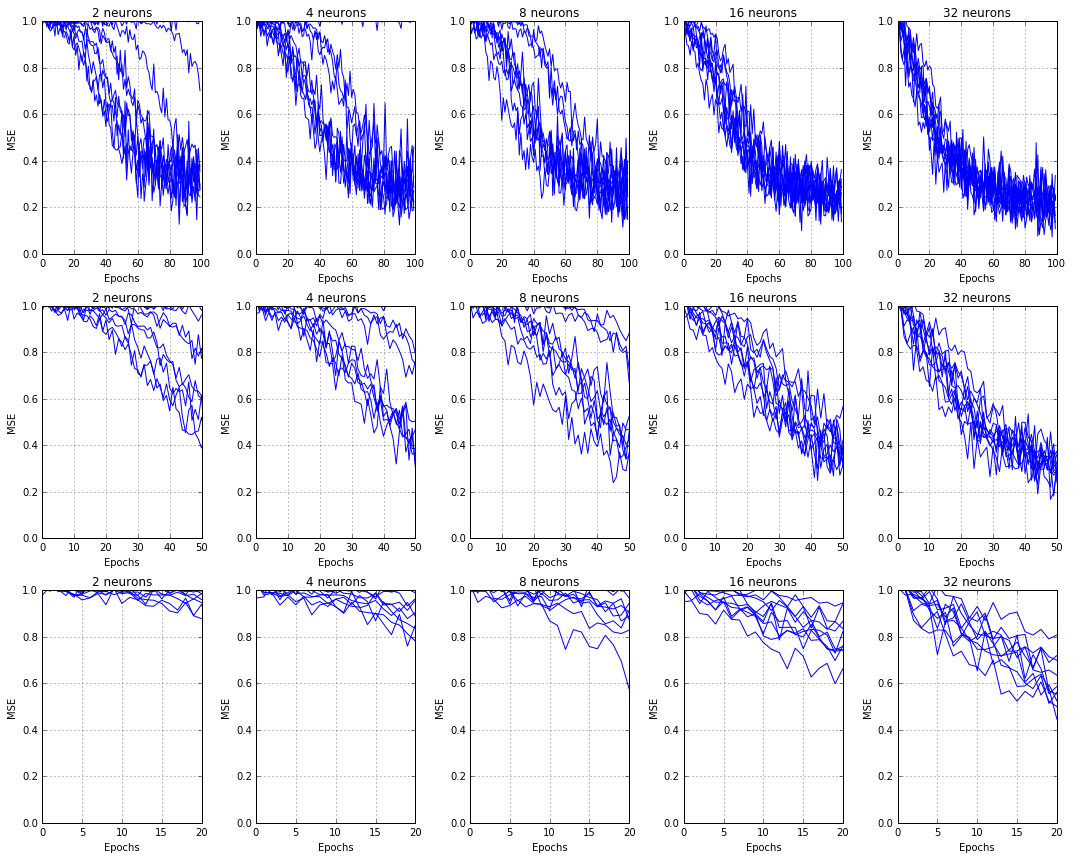

In [148]:
pl.figure(figsize=(15,12))
p_count = 0
for lim in [100, 50, 20]:
    for n in np.arange(MSE.shape[0]):
        p_count += 1
        pl.subplot(3,MSE.shape[0], p_count)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlim(0,lim)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
pl.tight_layout()

## Exploring the number of hidden neurons

In [149]:
EPOCHS = [20, 50, 100]
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [150]:
MSE_train = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))

for i_e, e in enumerate(EPOCHS):                                            # looping the number of epochs
    print 'Testing with', e, 'epochs...'
    for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
        print '\tTesting', h, 'neurons...'
        nn = mlp.MLP([13,h,1], 'tanh')
        for i in np.arange(N_TESTS):                                        # looping the tests
            temp1, temp2 = cv.k_fold_cross_validation(nn,
                                                      dataset,
                                                      k=K,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum=MOMENTUM,
                                                      epochs=e)
            MSE_train[i_h, i_e, i] = temp1
            MSE_test[i_h, i_e, i] = temp2

Testing with 20 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 50 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 100 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


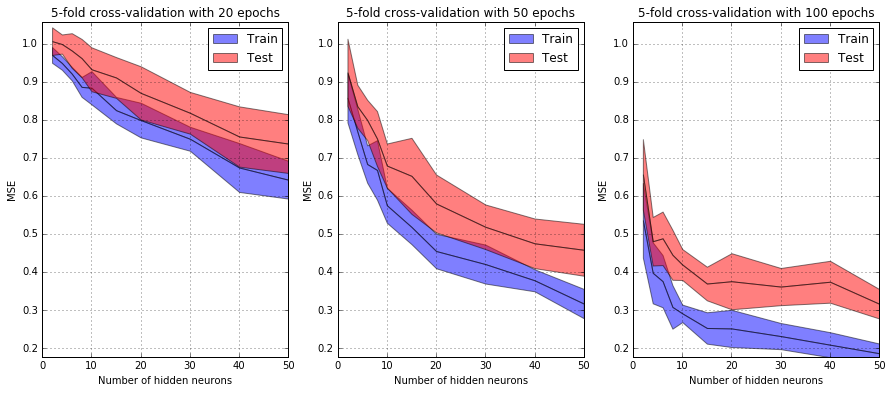

In [151]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

pl.figure(figsize=(15,6))
for i_e, e in enumerate(EPOCHS):
    pl.subplot(1,3,i_e+1)
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]+MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]-MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5)
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]+MSE_test_sd[:,i_e], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]-MSE_test_sd[:,i_e], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.05*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of hidden neurons')
    pl.title(str(K)+'-fold cross-validation with '+str(e)+' epochs')
    pl.legend()
    pl.grid()

## Exploring the number of epochs and the number of hidden neurons at the same time

In [152]:
EPOCHS = 100

In [153]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print '\tTesting', h, 'neurons...'
    nn = mlp.MLP([13,h,1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


In [154]:
min(np.min(MSE_train), np.min(MSE_test))

0.16710076344870844

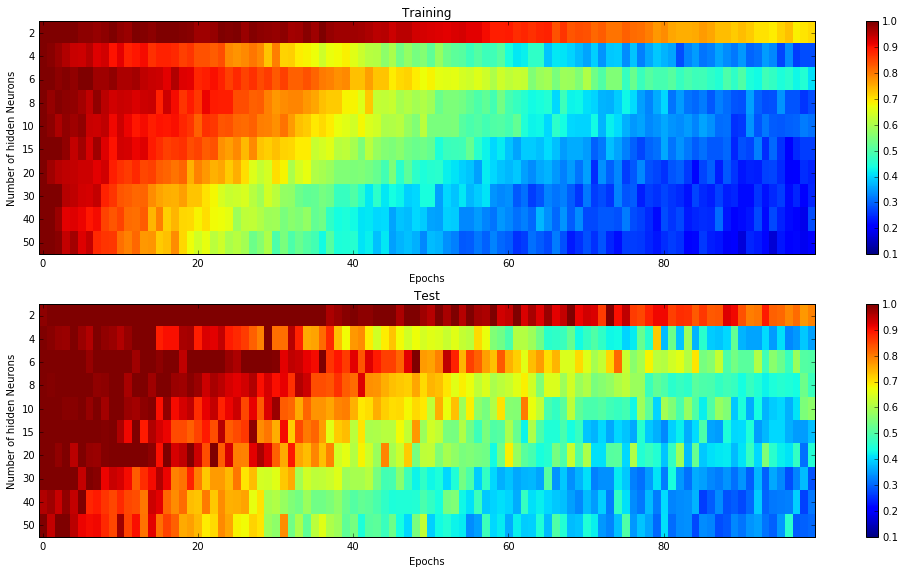

In [155]:
#v_min = min(np.min(MSE_train), np.min(MSE_test))
v_min = 0.1   # tune these values to enhance visualization
v_max = 1

pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

## The final model

In [156]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [157]:
print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

MSE training:  0.210054376487
MSE test:  0.347516800076
Confusion matrix:
[[ 35.   1.]
 [  6.  30.]]


# 7.2

In [158]:
nkFiles = []

for f in files:
    if f.startswith("nk"):
        nkFiles.append(wav.read(BASE_DIR + f))

In [159]:
nkCeps = []
for f in nkFiles:
    nkCeps.append(mfcc(f[1], fs=f[0])[0])

In [169]:
nkMeanCeps = []
for c in nkCeps:
    nkMeanCeps.append(np.mean(c, axis=0))

In [171]:
dsf = np.array(map(lambda x: np.append(x, 1), nkMeanCeps))
dsm = np.array(map(lambda x: np.append(x, -1), namMeanCeps))
dataset = np.append(dsf, dsm, axis=0)

In [172]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [173]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = mlp.MLP([13,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:15]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


In [ ]:
pl.figure(figsize=(15,12))
p_count = 0
for lim in [100, 50, 20]:
    for n in np.arange(MSE.shape[0]):
        p_count += 1
        pl.subplot(3,MSE.shape[0], p_count)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlim(0,lim)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
pl.tight_layout()

## Exploring the number of hidden neurons

In [174]:
EPOCHS = [20, 50, 100]
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [ ]:
MSE_train = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))

for i_e, e in enumerate(EPOCHS):                                            # looping the number of epochs
    print 'Testing with', e, 'epochs...'
    for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
        print '\tTesting', h, 'neurons...'
        nn = mlp.MLP([13,h,1], 'tanh')
        for i in np.arange(N_TESTS):                                        # looping the tests
            temp1, temp2 = cv.k_fold_cross_validation(nn,
                                                      dataset,
                                                      k=K,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum=MOMENTUM,
                                                      epochs=e)
            MSE_train[i_h, i_e, i] = temp1
            MSE_test[i_h, i_e, i] = temp2

Testing with 20 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 50 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 100 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing

In [ ]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

pl.figure(figsize=(15,6))
for i_e, e in enumerate(EPOCHS):
    pl.subplot(1,3,i_e+1)
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]+MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]-MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5)
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]+MSE_test_sd[:,i_e], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]-MSE_test_sd[:,i_e], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.05*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of hidden neurons')
    pl.title(str(K)+'-fold cross-validation with '+str(e)+' epochs')
    pl.legend()
    pl.grid()

## Exploring the number of epochs and the number of hidden neurons at the same time

In [ ]:
EPOCHS = 100

In [ ]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print '\tTesting', h, 'neurons...'
    nn = mlp.MLP([13,h,1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

In [ ]:
min(np.min(MSE_train), np.min(MSE_test))

In [ ]:
#v_min = min(np.min(MSE_train), np.min(MSE_test))
v_min = 0.1   # tune these values to enhance visualization
v_max = 1

pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

## The final model

In [ ]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [ ]:
print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

# 7.3

In [ ]:
dsf = np.array(map(lambda x: np.append(x, 1), nafMeanCeps))
dsm = np.array(map(lambda x: np.append(x, -1), nkMeanCeps))
dataset = np.append(dsf, dsm, axis=0)

In [146]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [147]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = mlp.MLP([13,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:15]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


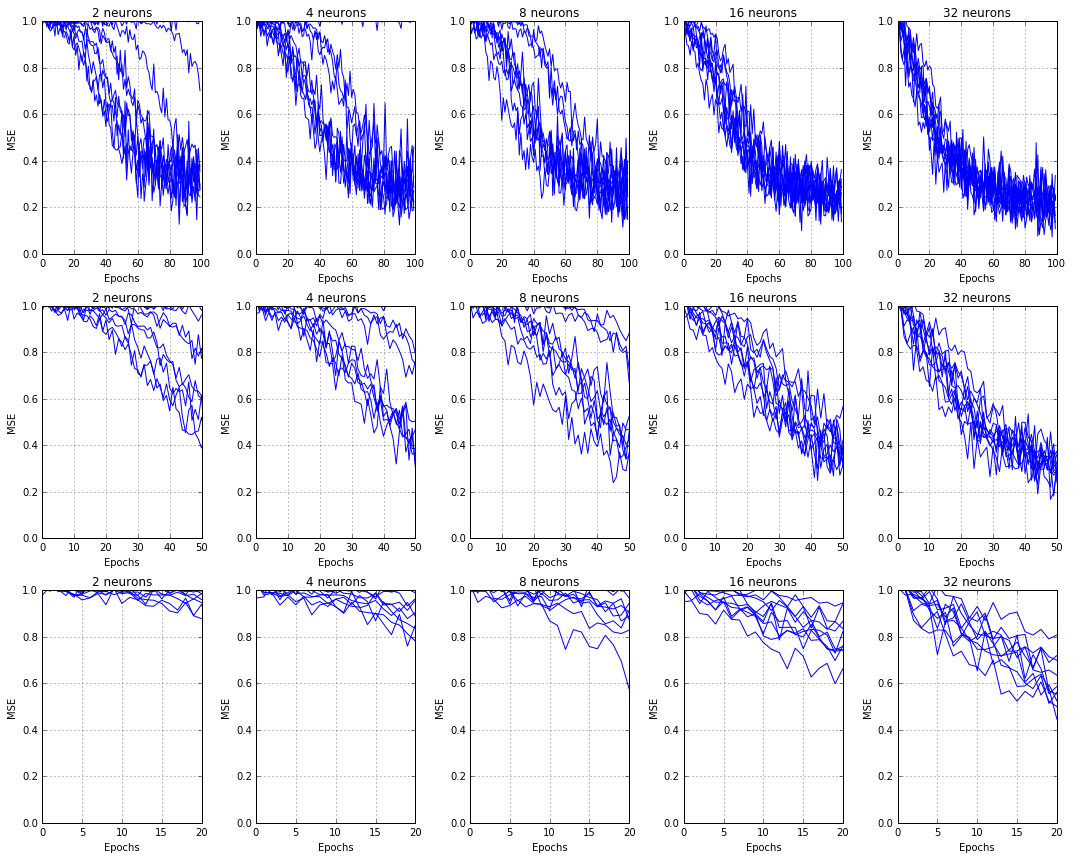

In [148]:
pl.figure(figsize=(15,12))
p_count = 0
for lim in [100, 50, 20]:
    for n in np.arange(MSE.shape[0]):
        p_count += 1
        pl.subplot(3,MSE.shape[0], p_count)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlim(0,lim)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
pl.tight_layout()

## Exploring the number of hidden neurons

In [149]:
EPOCHS = [20, 50, 100]
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [150]:
MSE_train = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))

for i_e, e in enumerate(EPOCHS):                                            # looping the number of epochs
    print 'Testing with', e, 'epochs...'
    for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
        print '\tTesting', h, 'neurons...'
        nn = mlp.MLP([13,h,1], 'tanh')
        for i in np.arange(N_TESTS):                                        # looping the tests
            temp1, temp2 = cv.k_fold_cross_validation(nn,
                                                      dataset,
                                                      k=K,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum=MOMENTUM,
                                                      epochs=e)
            MSE_train[i_h, i_e, i] = temp1
            MSE_test[i_h, i_e, i] = temp2

Testing with 20 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 50 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 100 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


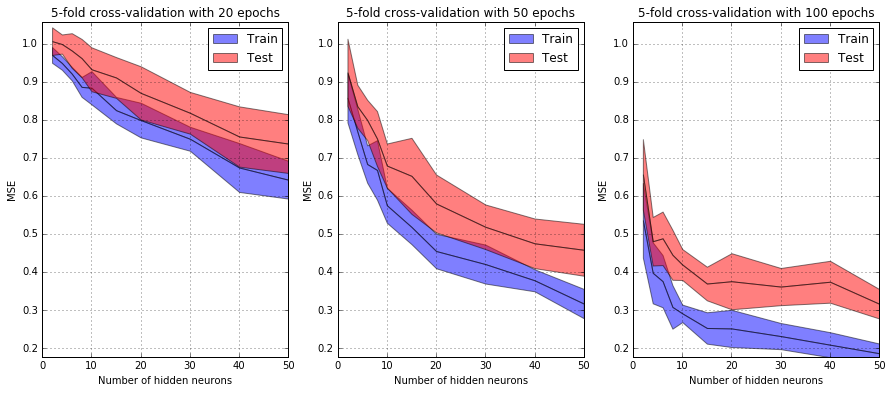

In [151]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

pl.figure(figsize=(15,6))
for i_e, e in enumerate(EPOCHS):
    pl.subplot(1,3,i_e+1)
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]+MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]-MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5)
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]+MSE_test_sd[:,i_e], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]-MSE_test_sd[:,i_e], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.05*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of hidden neurons')
    pl.title(str(K)+'-fold cross-validation with '+str(e)+' epochs')
    pl.legend()
    pl.grid()

## Exploring the number of epochs and the number of hidden neurons at the same time

In [152]:
EPOCHS = 100

In [153]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print '\tTesting', h, 'neurons...'
    nn = mlp.MLP([13,h,1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


In [154]:
min(np.min(MSE_train), np.min(MSE_test))

0.16710076344870844

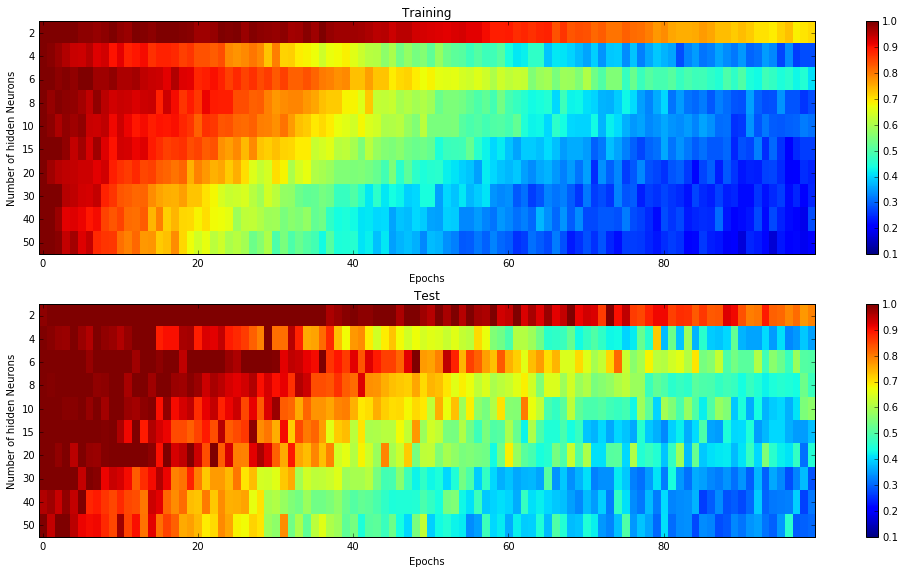

In [155]:
#v_min = min(np.min(MSE_train), np.min(MSE_test))
v_min = 0.1   # tune these values to enhance visualization
v_max = 1

pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

## The final model

In [156]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [157]:
print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

MSE training:  0.210054376487
MSE test:  0.347516800076
Confusion matrix:
[[ 35.   1.]
 [  6.  30.]]


# 7.4

# 7.5

In [161]:
naturalFiles = []
synthesizedFiles = []

for f in files:
    if "n" in f:
        naturalFiles.append(wav.read(BASE_DIR + f))
    if "s" in f:
        synthesizedFiles.append(wav.read(BASE_DIR + f))

In [162]:
naturalCeps = []
for f in naturalFiles:
    naturalCeps.append(mfcc(f[1], fs=f[0])[0])

synthesizedCeps = []
for f in synthesizedFiles:
    synthesizedCeps.append(mfcc(f[1], fs=f[0])[0])

In [163]:
naturalMeanCeps = []
for c in naturalCeps:
    naturalMeanCeps.append(np.mean(c, axis=0))

In [ ]:
synthesizedMeanCeps = []
for c in synthesizedCeps:
    synthesizedMeanCeps.append(np.mean(c, axis=0))

In [145]:
dsf = np.array(map(lambda x: np.append(x, 1), naturalMeanCeps))
dsm = np.array(map(lambda x: np.append(x, -1), synthesizedMeanCeps))
dataset = np.append(dsf, dsm, axis=0)

In [146]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [147]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = mlp.MLP([13,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:15]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


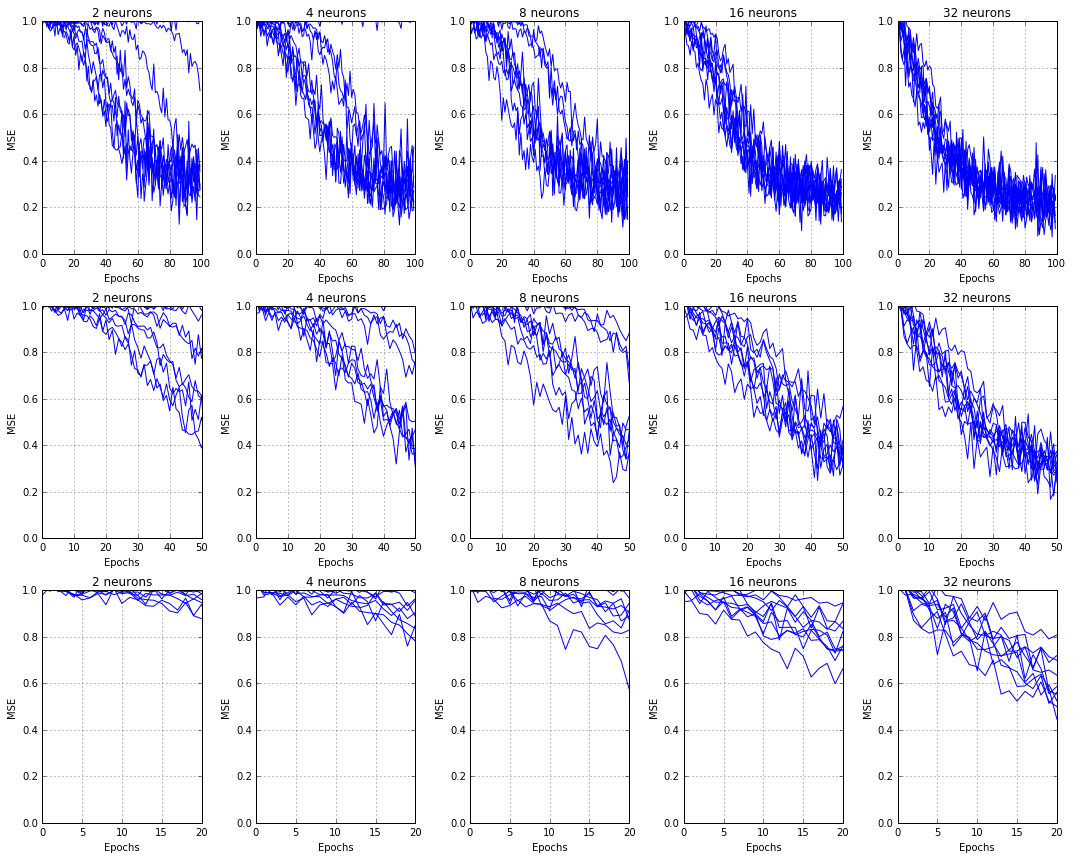

In [148]:
pl.figure(figsize=(15,12))
p_count = 0
for lim in [100, 50, 20]:
    for n in np.arange(MSE.shape[0]):
        p_count += 1
        pl.subplot(3,MSE.shape[0], p_count)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlim(0,lim)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
pl.tight_layout()

## Exploring the number of hidden neurons

In [149]:
EPOCHS = [20, 50, 100]
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [150]:
MSE_train = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))

for i_e, e in enumerate(EPOCHS):                                            # looping the number of epochs
    print 'Testing with', e, 'epochs...'
    for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
        print '\tTesting', h, 'neurons...'
        nn = mlp.MLP([13,h,1], 'tanh')
        for i in np.arange(N_TESTS):                                        # looping the tests
            temp1, temp2 = cv.k_fold_cross_validation(nn,
                                                      dataset,
                                                      k=K,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum=MOMENTUM,
                                                      epochs=e)
            MSE_train[i_h, i_e, i] = temp1
            MSE_test[i_h, i_e, i] = temp2

Testing with 20 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 50 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 100 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


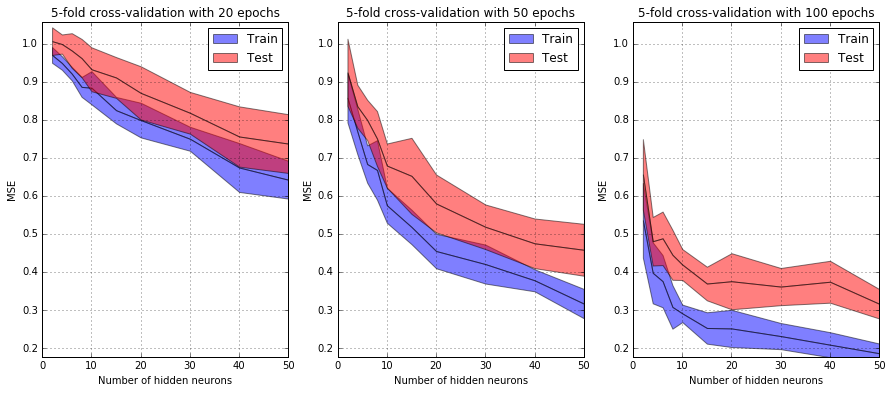

In [151]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

pl.figure(figsize=(15,6))
for i_e, e in enumerate(EPOCHS):
    pl.subplot(1,3,i_e+1)
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]+MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]-MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5)
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]+MSE_test_sd[:,i_e], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]-MSE_test_sd[:,i_e], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.05*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of hidden neurons')
    pl.title(str(K)+'-fold cross-validation with '+str(e)+' epochs')
    pl.legend()
    pl.grid()

## Exploring the number of epochs and the number of hidden neurons at the same time

In [152]:
EPOCHS = 100

In [153]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print '\tTesting', h, 'neurons...'
    nn = mlp.MLP([13,h,1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


In [154]:
min(np.min(MSE_train), np.min(MSE_test))

0.16710076344870844

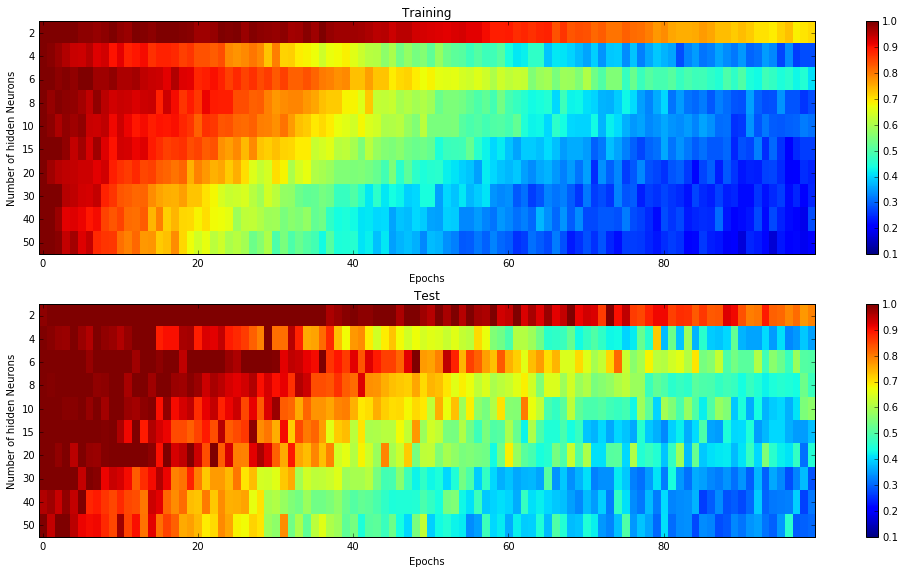

In [155]:
#v_min = min(np.min(MSE_train), np.min(MSE_test))
v_min = 0.1   # tune these values to enhance visualization
v_max = 1

pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

## The final model

In [156]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [157]:
print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

MSE training:  0.210054376487
MSE test:  0.347516800076
Confusion matrix:
[[ 35.   1.]
 [  6.  30.]]


# 7.6 7yo vs 3yo

In [165]:
_3yoFiles = []
_7yoFiles = []

for f in files:
    if f.startswith("nk3"):
        _3yoFiles.append(wav.read(BASE_DIR + f))
    if f.startswith("nk7"):
        _7yoFiles.append(wav.read(BASE_DIR + f))

In [166]:
_3yoCeps = []
for f in _3yoFiles:
    _3yoCeps.append(mfcc(f[1], fs=f[0])[0])

_7yoCeps = []
for f in _7yoFiles:
    _7yoCeps.append(mfcc(f[1], fs=f[0])[0])

In [167]:
_3yoMeanCeps = []
for c in naturalCeps:
    _3yoMeanCeps.append(np.mean(c, axis=0))

In [ ]:
_7yoMeanCeps = []
for c in naturalCeps:
    _7yoMeanCeps.append(np.mean(c, axis=0))

In [145]:
dsf = np.array(map(lambda x: np.append(x, 1), _3yoMeanCeps))
dsm = np.array(map(lambda x: np.append(x, -1), _7yoMeanCeps))
dataset = np.append(dsf, dsm, axis=0)

In [146]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [147]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = mlp.MLP([13,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:15]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


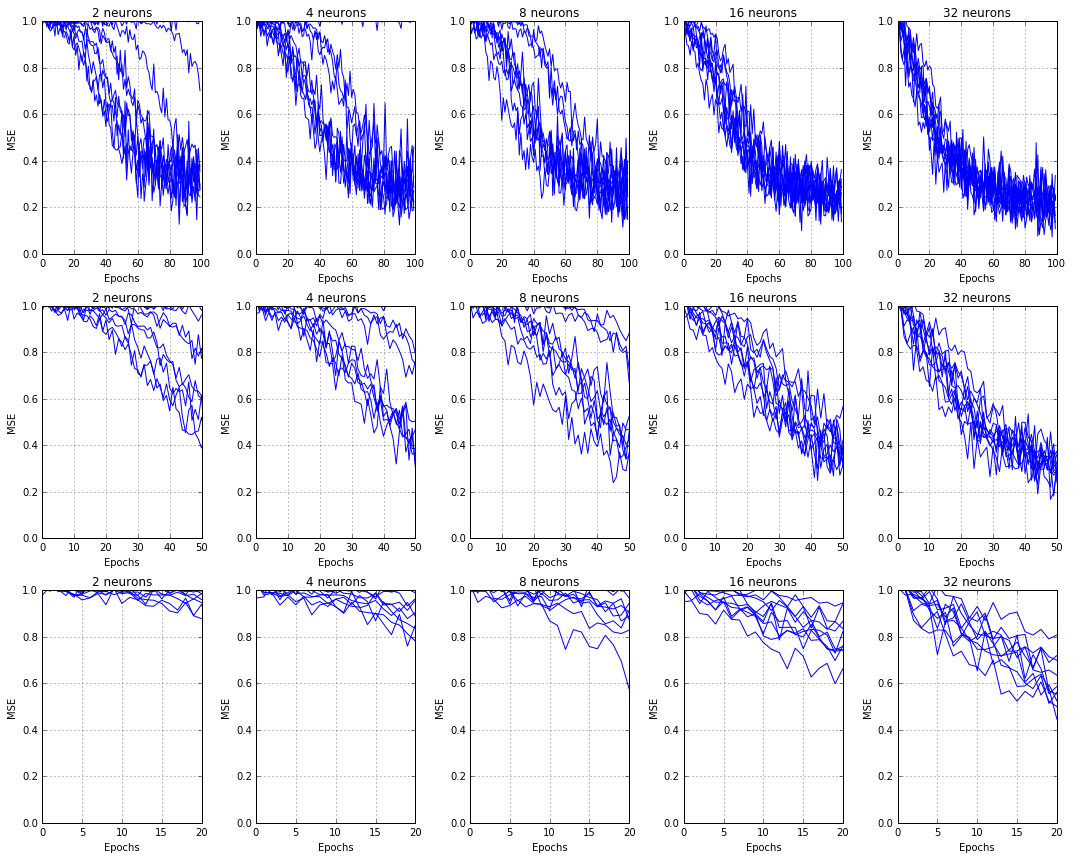

In [148]:
pl.figure(figsize=(15,12))
p_count = 0
for lim in [100, 50, 20]:
    for n in np.arange(MSE.shape[0]):
        p_count += 1
        pl.subplot(3,MSE.shape[0], p_count)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlim(0,lim)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
pl.tight_layout()

## Exploring the number of hidden neurons

In [149]:
EPOCHS = [20, 50, 100]
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [150]:
MSE_train = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))

for i_e, e in enumerate(EPOCHS):                                            # looping the number of epochs
    print 'Testing with', e, 'epochs...'
    for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
        print '\tTesting', h, 'neurons...'
        nn = mlp.MLP([13,h,1], 'tanh')
        for i in np.arange(N_TESTS):                                        # looping the tests
            temp1, temp2 = cv.k_fold_cross_validation(nn,
                                                      dataset,
                                                      k=K,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum=MOMENTUM,
                                                      epochs=e)
            MSE_train[i_h, i_e, i] = temp1
            MSE_test[i_h, i_e, i] = temp2

Testing with 20 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 50 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 100 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


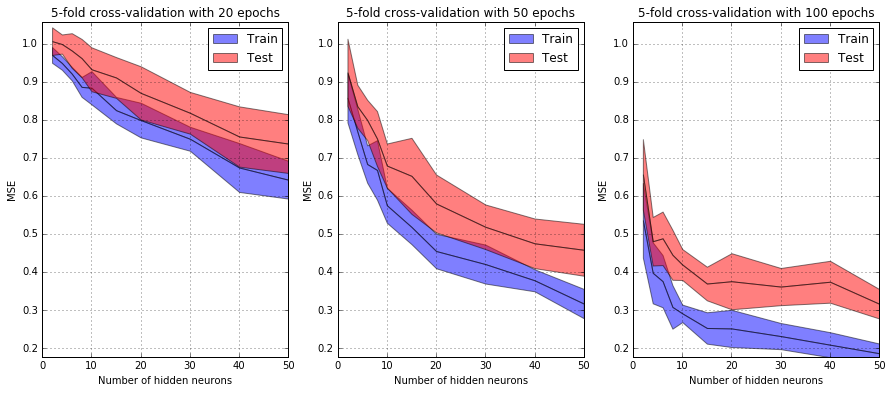

In [151]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

pl.figure(figsize=(15,6))
for i_e, e in enumerate(EPOCHS):
    pl.subplot(1,3,i_e+1)
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]+MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]-MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5)
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]+MSE_test_sd[:,i_e], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]-MSE_test_sd[:,i_e], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.05*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of hidden neurons')
    pl.title(str(K)+'-fold cross-validation with '+str(e)+' epochs')
    pl.legend()
    pl.grid()

## Exploring the number of epochs and the number of hidden neurons at the same time

In [152]:
EPOCHS = 100

In [153]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print '\tTesting', h, 'neurons...'
    nn = mlp.MLP([13,h,1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


In [154]:
min(np.min(MSE_train), np.min(MSE_test))

0.16710076344870844

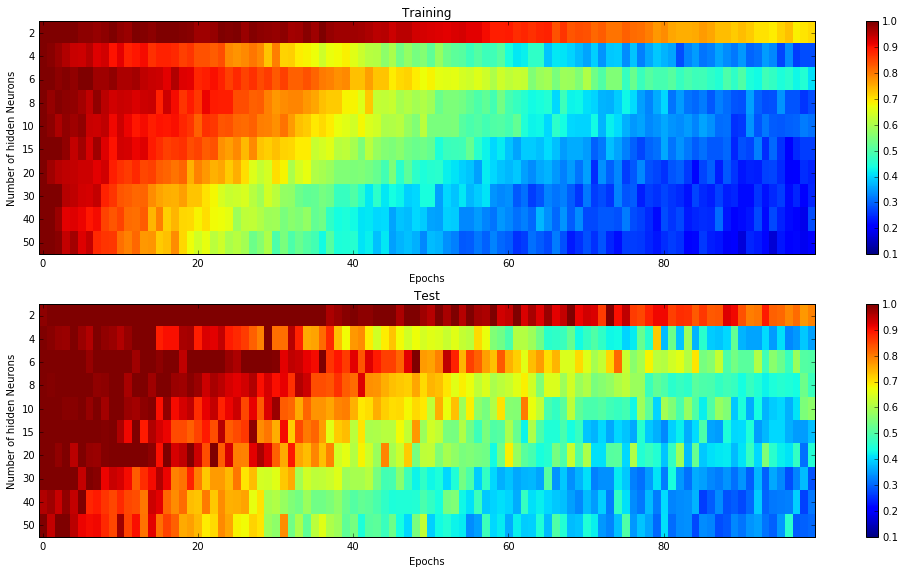

In [155]:
#v_min = min(np.min(MSE_train), np.min(MSE_test))
v_min = 0.1   # tune these values to enhance visualization
v_max = 1

pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

## The final model

In [156]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [157]:
print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

MSE training:  0.210054376487
MSE test:  0.347516800076
Confusion matrix:
[[ 35.   1.]
 [  6.  30.]]
